<a href="https://colab.research.google.com/github/Mercymerine/ML2_notes/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means vs. Gaussian Mixture Models (GMMs): A Fun and Intuitive Comparison!
🚀

**K-Means: Simple, but Not Always Smart**

K-Means is a straightforward clustering method that assumes:

1. Clusters are circular.
2.The mean of each cluster is at its center.

This works well for neat, round clusters. However, it struggles when:

1. Clusters overlap (e.g., two circles sharing the same center).
2. Clusters aren’t circular (think elliptical or irregular shapes).

In short, K-Means is like using a cookie-cutter to divide your data—it’s fast but rigid.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np


In [ ]:

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

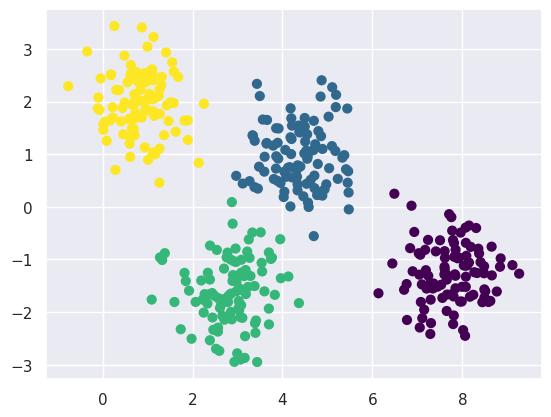

In [ ]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

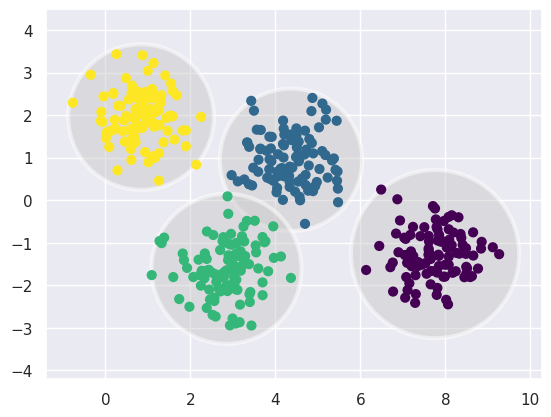

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)


An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

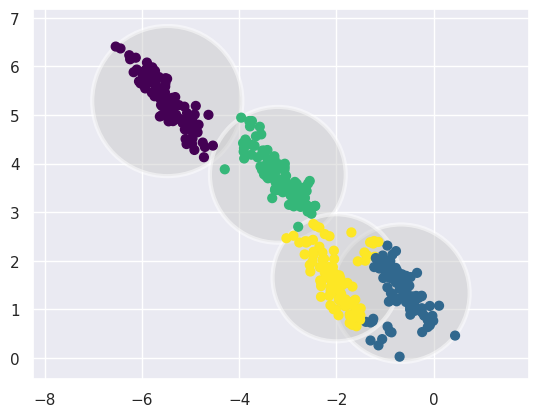

In [ ]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)


By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.

# Why GMMs Are the Upgrade You Need 🎩

Gaussian Mixture Models (GMMs) take clustering to the next level with flexibility and probabilistic smarts:

1. **Flexible Shapes:**
GMMs assume clusters follow a Gaussian distribution (bell curve). This lets them form:

  1. Elliptical shapes
  2. Clusters tilted or stretched in any direction

2. **Probabilities Instead of Hard Assignments:**
Unlike K-Means, which says, “This point belongs 100% to Cluster A,” GMMs say:
“This point is 60% Cluster A and 40% Cluster B.”

This soft assignment approach makes GMMs better for real-world data, where boundaries are often fuzzy.

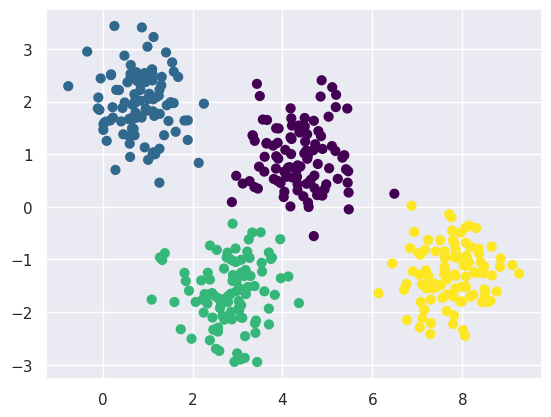

In [ ]:

from sklearn.mixture import GaussianMixture as GMM


gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [ ]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.    0.    0.469]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


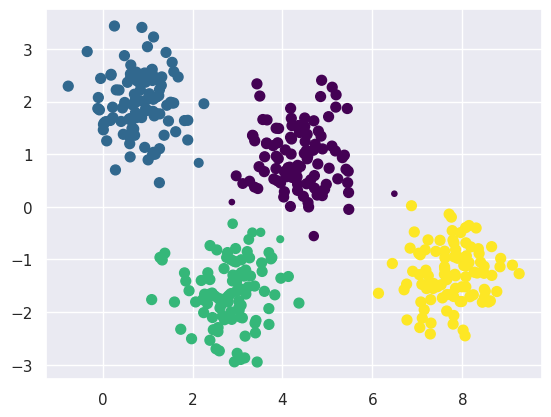

In [ ]:

size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

# How GMMs Work: The Magic of Expectation-Maximization (EM) 🪄

1. Start with a Guess:
Randomly initialize each cluster's mean and shape (standard deviation).

2. Compute Probabilities:
For each point, calculate how likely it belongs to each cluster. Points closer to the center have higher probabilities.

3. Update the Clusters:
Adjust the cluster means and shapes based on the data. For example:

  If most points are on the right, the mean shifts there.
  If points stretch in a diagonal, the shape elongates to fit.

4. Repeat Until Done:
Iterate until the clusters stop changing much.

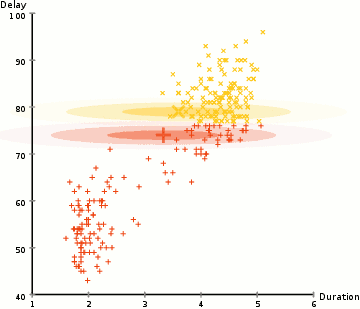

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture as GMM

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance."""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    """Plot the Gaussian mixture model."""
    ax = ax or plt.gca()
    labels = gmm.predict(X)

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)





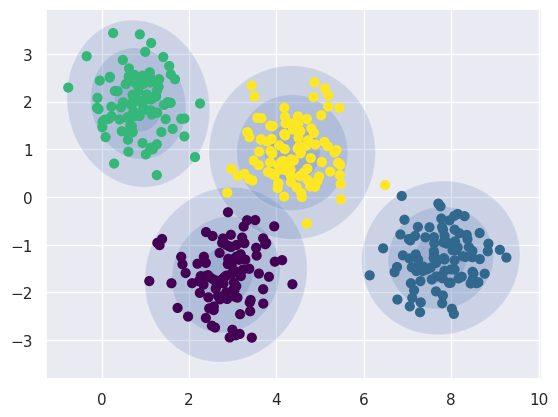

In [ ]:
gmm = GMM(n_components=4, random_state=42)

gmm.fit(X)
plot_gmm(gmm, X)
plt.show()

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

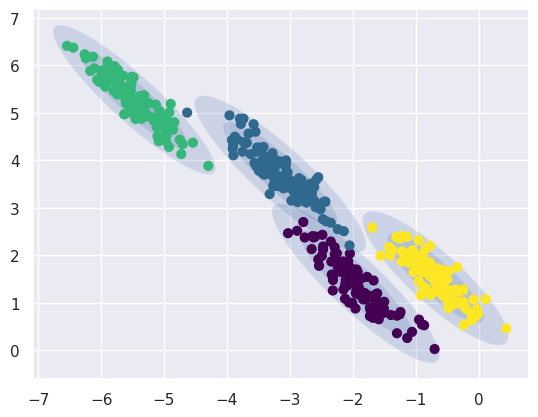

In [ ]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)


gmm.fit(X_stretched)

plot_gmm(gmm, X_stretched)

**Components**
Think of components as different groups or clusters within your data. Each component is like a type of fruit in a fruit salad. If you have apples, oranges, and bananas, each fruit type represents a different component. The GMM will use these components to represent different clusters or groups in your data.

**Covariance Type**
Covariance describes how much two random variables vary together. In GMMs, the covariance type tells the model how to consider the shape and orientation of the clusters.

**Here are the different covariance types:**

**Spherical:**Imagine each fruit (component) is perfectly round like a tennis ball. Every fruit is the same size and shape.

**Diagonal:** Each fruit can vary in size but is still symmetrical. Think of it like different sizes of lemons—they're all lemon-shaped but can be small or large.

**Tied:** All fruits share the same shape, like all being apples, but they can vary in size.

**Full:** Each fruit can have a completely unique shape and size. It's like having apples, bananas, and pineapples, where each fruit (component) can be any shape and size.

Cluster Representation:

A GMM assumes your data is made up of overlapping "blobs" (or clusters) that follow a bell-shaped curve (Gaussian distribution).
Each blob has:
Mean (center): The middle point of the blob.
Covariance (spread and orientation): How wide, narrow, or tilted the blob is.

components: number of fruits in your salad
covariance: size and shape